# Introduction

This is a GumbelSoftmax variational autoencoder (VAE) implementation in Keras. Its purpose is to explore the viability of a discrete latent representation of a simple 2D top-down game, for later use in a Reinforcement Learning agent.

The theory is based on the work in the paper "Categorical Reparameterization with Gumbel-Softmax" (https://arxiv.org/pdf/1611.01144.pdf)

With code developed from (https://github.com/EderSantana/gumbel) and (https://github.com/ericjang/gumbel-softmax)


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Conv2DTranspose, Reshape, Activation
from keras.models import Model, Sequential
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.activations import softmax
from keras.objectives import binary_crossentropy as bce
from keras.objectives import mean_squared_error as mse


%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


# The Gumbel-Softmax distribution

Representing discrete real world problems with categorical variables, is in obvious choice. They are however, not easy to use with models that rely on backpropagation, because of their discrete nature. As with many things in science, a sufficient approximation can be used instead.  
The Gumbel-Softmax distribution is such an approximation. It is controlled by a temperature parameter, $ \tau $, that interpolates between discrete one-hot encoded categorical distributions and continuous categorical densities.

<img src="gumbel_softmax_dist.png">

The following paragraph from "Categorical Reparameterization with Gumbel-Softmax" (section "2 - The Gumbel-Softmax Distribution) describes the choice of softmax and the resulting samples drawn from it:

<blockquote cite="https://arxiv.org/pdf/1611.01144.pdf">
The Gumbel-Max trick (Gumbel, 1954; Maddison et al., 2014) provides a simple and efficient way to draw samples $z$ from a categorical distribution with class probabilities $\pi$:

$$ z = \text{one_hot} \big( \arg\max_i [g_i + \log \pi_i] \big) $$

where $g_1...g_k$ are i.i.d samples drawn from Gumbel(0,1). We use the softmax function as a continuous, differentiable approximation to arg max, and generate $k$-dimensional sample vectors $y$, where

$$ y_i = \frac{ \exp ((\log (\pi_i) + g_i) / \tau) }{ \sum_{j=1}^{k} \exp ((\log (\pi_j) + g_j) / \tau) } \quad \text{for } i = 1,...,k $$

</blockquote>

## Loss and Sampling functions

### Loss
The loss function is comprised of two terms: the reconstruction loss and the KL divergence.
The reconstruction loss is a measure of the difference between the original image and the reconstructed one, and in the perfect situation this would be zero (perfect reconstruction).

$$ \text{reconstruction_loss} = \text{nr_pixels} \times \text{MSE}(x, \tilde x) $$

The KL divergence measures how the encoder distribution, $q(z)$, differs from the uniform prior distribution $p(z)$. This divergence serves as a regularization term, meant to force the distribution as close to a uniform distribution, without losing too much reconstruction ability. In the perfection situation, this will not reach zero, as that would indicate a random distribution, and an decoder that has learned nothing.  
The KL divergence code is based on the following math

$$ KL(q \parallel p) = \sum q(z) \times \log \frac{q(z)}{p(z)} $$

$$ KL(q \parallel p) = \sum q(z) \times \lbrack \log q(z) - \log p(z) \rbrack $$

$$ KL(q \parallel p) = \sum q(z) \times \lbrack \log q(z) - \log \frac{1}{m} \rbrack $$

with $m$ being the number of categories in the categorical distribution.

### Sampling
The Gumbel distribution can be sampled using inverse transform sampling (see the paper this work is based on)
$$ g = -log(-log(u)) $$ 
with $u$ sampled from a Uniform distribution
$$ u \sim Uniform(0,1) $$

In [3]:
# Sample with log probabilities (consistent with theory)
def sampling(logits_y):
    U = K.random_uniform(K.shape(logits_y), 0, 1)
    q_y = K.reshape(logits_y, (-1, N, M))
    q_y = softmax(q_y)
    log_q_y = K.log(q_y + 1e-20)
    log_q_y = K.reshape(log_q_y, (-1, N*M))
    y = log_q_y - K.log(-K.log(U + 1e-20) + 1e-20) # logits + gumbel noise
    y = softmax(K.reshape(y, (-1, N, M)) / tau)
    y = K.reshape(y, (-1, N*M))
    return y


def gumbel_loss(x, x_hat):
    # calc KL divergence
    q_y = K.reshape(logits_y, (-1, N, M)) # reshape: batches, N*M --> batches, N, M
    q_y = softmax(q_y)
    log_q_y = K.log(q_y + 1e-20)
    kl_tmp = q_y * (log_q_y - K.log(1.0/M)) # 1.0/M: uniform prior, all options equally likely
    KL = K.sum(kl_tmp, axis=(1, 2))
    # reshape x and x_hat into vectors (required by keras)
    x = K.reshape(x, (1,-1))
    x_hat = K.reshape(x_hat, (1,-1))
    # final loss
    elbo = DATA_DIM * mse(x, x_hat) - KL
    return elbo

# Model
Convolutional neural networks are used in both the encoder and decoder of the autoencoder.

In [9]:
batch_size = 64
IMAGE_DIM = (64,64,3)
INPUT_DIM = (64,64,3)
DATA_DIM = 12288 # = 64x64x3
N = 10
M = 6
nb_epochs = 100 #100
epsilon_std = 0.01

anneal_rate = 0.0003 # used to lower temperature during training
max_temperature = 2.0
min_temperature = 0.5

tau = K.variable(max_temperature, name="temperature")
ACTIV = "relu"


In [6]:
# ======= DEFINE MODEL

# ENCODER
x = Input(shape=INPUT_DIM)
h = Conv2D(filters=32, kernel_size=4, strides=2, padding='same', activation=ACTIV)(x)
h = Conv2D(filters=64, kernel_size=4, strides=2, padding='same', activation=ACTIV)(h)
h = Conv2D(filters=128, kernel_size=4, strides=2, padding='same', activation=ACTIV)(h)
h = Flatten()(h)

logits_y = Dense(M*N, activation=None)(h)

# SAMPLING LAYER
z_lay = Lambda(sampling, output_shape=(M*N,))
z = z_lay(logits_y)
z_ = Activation(None)(z) # used for testing the output

# DECODER
z_1 = Reshape((1,1,N*M))
z_2 = Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding="same", activation=ACTIV)
z_3 = Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding="same", activation=ACTIV)
z_4 = Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding="same", activation=ACTIV)
z_5 = Conv2DTranspose(filters=16, kernel_size=4, strides=2, padding="same", activation=ACTIV)
z_6 = Conv2DTranspose(filters=16, kernel_size=4, strides=2, padding="same", activation=ACTIV)
x_hat = Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding="same", activation="sigmoid")

## The decoding part is used in two different models, so that it's possible to use the decoder separately afterwards
# Decoder part of the full network
decoded_x = x_hat(z_6(z_5(z_4(z_3(z_2(z_1( z )))))))


# The separate decoder model, called generator
decode_input = Input( shape=(M*N,) ) # input-layer with same dimensionality as the output from sampling layer (z)
decoder = x_hat(z_6(z_5(z_4(z_3(z_2(z_1( decode_input ))))))) # apply previous input layer to the decoder layers
generator = Model(decode_input, decoder)

# used for testing the ouput of the different layers
vae_test = Model(x, [decoded_x, logits_y, z_])

# the final full network
vae = Model(x, decoded_x)

# Custom metrics: reconstruction loss and KL divergence
# reconstruction loss
def recon_loss(x, x_hat):
    return DATA_DIM * mse(x, x_hat)

# KL divergence
def kl_div(x, x_hat):
    q_y = K.reshape(logits_y, (-1, N, M))
    q_y = softmax(q_y)
    log_q_y = K.log(q_y + 1e-20)
    kl_tmp = q_y * (log_q_y - K.log(1.0/M))
    KL = K.sum(kl_tmp, axis=(1, 2))
    return KL

optim = keras.optimizers.Adam(lr=0.0005)

vae.compile(optimizer=optim, 
            loss=gumbel_loss,
            metrics=[recon_loss, kl_div])
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                491580    
_________________________________________________________________
lambda_2 (Lambda)            (None, 60)                0         
__________

# Import data

In [7]:
import os
data_dir = "world_models_data"
data1 = "small_obs_data_car_racing_1.npy"
np_dat = np.load(os.path.join(data_dir, data1))
np.random.shuffle(np_dat)

x_train = np_dat[:8000]
x_test = np_dat[8000:]
print(x_train.shape, x_test.shape)

(8000, 64, 64, 3) (2000, 64, 64, 3)


The race car game is an OpenAI Gym environment, with the task of controlling a car along a track. The car is fixed in bottom center of the image. There are no obstacles or opponents. The difficulty lie in following the road.

The states (images) have been downsampled from 96x96x3 to 64x64x3. This leaves the car as a simple red dot. But since it is fixed and the world spins aroud it, no vital information is lost by it being a simple dot.

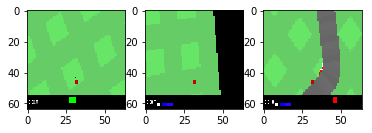

In [8]:
# Sample images
subplot(131)
imshow(x_test[100])
subplot(132)
imshow(x_test[170])
subplot(133)
imshow(x_test[230])

# Training

In [10]:
# Callback for keras training
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.taus = []
        self.kls = []

    # update temperature after each epoch
    def on_epoch_end(self, epoch, logs=None):
#         K.set_value(tau, np.max([K.get_value(tau) * np.exp(- anneal_rate * epoch), min_temperature]))
        K.set_value(tau, get_temp(max_temperature, min_temperature, nb_epochs, epoch))
        self.taus.append( K.get_value(tau) )
    
    # save the KL divergence after each batch
    def on_batch_end(self, batch, logs=None):
        self.kls.append( logs["kl_div"] )

        
# Evenly spaced temperatures between max and min temperature
def get_temp(max_tau, min_tau, nb_points, point):
    # TODO: wasteful to call linspace everytime, but just convenient during development (because nb_epochs changes)
    return np.linspace(max_tau, min_tau, nb_points)[point]


# Will contain list of temperature/tau values used during training
custom_callback = CustomCallback()

train_info = vae.fit(x_train, x_train, 
    shuffle=True, 
    epochs=nb_epochs, 
    batch_size=batch_size,
    validation_data=(x_test, x_test),
    callbacks=[custom_callback])

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 10s 1ms/step - loss: 681.4236 - recon_loss: 698.2714 - kl_div: 16.8478 - val_loss: 521.1297 - val_recon_loss: 539.0473 - val_kl_div: 17.9176
Epoch 2/100
8000/8000 [==============================] - 4s 561us/step - loss: 281.9889 - recon_loss: 299.9065 - kl_div: 17.9176 - val_loss: 241.9812 - val_recon_loss: 259.8988 - val_kl_div: 17.9176
Epoch 3/100
8000/8000 [==============================] - 4s 562us/step - loss: 217.4725 - recon_loss: 235.3252 - kl_div: 17.8528 - val_loss: 195.7486 - val_recon_loss: 213.6549 - val_kl_div: 17.9062
Epoch 4/100
8000/8000 [==============================] - 4s 547us/step - loss: 153.9493 - recon_loss: 171.8639 - kl_div: 17.9146 - val_loss: 127.3365 - val_recon_loss: 145.2494 - val_kl_div: 17.9129
Epoch 5/100
8000/8000 [==============================] - 4s 536us/step - loss: 117.1909 - recon_loss: 135.1051 - kl_div: 17.9142 - val_loss: 113.0431 - val_r

Epoch 84/100
8000/8000 [==============================] - 4s 452us/step - loss: 28.3396 - recon_loss: 45.9211 - kl_div: 17.5815 - val_loss: 29.5303 - val_recon_loss: 47.0959 - val_kl_div: 17.5656
Epoch 85/100
8000/8000 [==============================] - 4s 457us/step - loss: 28.2122 - recon_loss: 45.7755 - kl_div: 17.5633 - val_loss: 29.1655 - val_recon_loss: 46.7380 - val_kl_div: 17.5725
Epoch 86/100
8000/8000 [==============================] - 4s 466us/step - loss: 28.0925 - recon_loss: 45.6640 - kl_div: 17.5716 - val_loss: 28.7452 - val_recon_loss: 46.3097 - val_kl_div: 17.5645
Epoch 87/100
8000/8000 [==============================] - 4s 531us/step - loss: 28.0044 - recon_loss: 45.5618 - kl_div: 17.5574 - val_loss: 28.9139 - val_recon_loss: 46.4486 - val_kl_div: 17.5347
Epoch 88/100
8000/8000 [==============================] - 4s 555us/step - loss: 27.8777 - recon_loss: 45.4371 - kl_div: 17.5595 - val_loss: 28.8875 - val_recon_loss: 46.4152 - val_kl_div: 17.5277
Epoch 89/100
8000/80

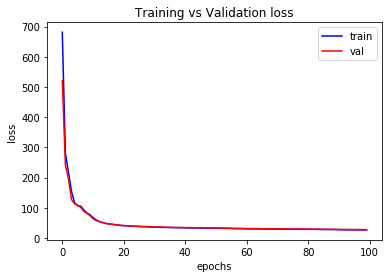

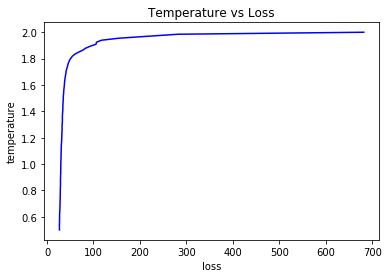

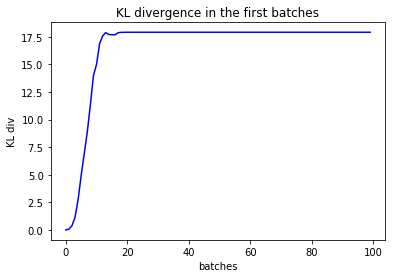

In [11]:
# extract the different metrics
np_loss = np.asarray(train_info.history["loss"])
np_val_loss = np.asarray(train_info.history["val_loss"])
np_recon_loss = np.asarray(train_info.history["recon_loss"])
np_kl_div = np.asarray(train_info.history["kl_div"])

# Training vs validation loss
t = range(nb_epochs)
plt.plot(t, np_loss, 'b-', label="train") 
plt.plot(t, np_val_loss, 'r-', label="val")
plt.title("Training vs Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.show()

# Temperature vs Loss
t = custom_callback.taus
plt.plot(np_loss, t, 'b-', label="train") 
plt.title("Temperature vs Loss")
plt.xlabel("loss")
plt.ylabel("temperature")
plt.show()

# KL divergence in the first couple of batches
t = range(100)
plt.plot(t, custom_callback.kls[:100], 'b-', label="Reconstruction") 
plt.title("KL divergence in the first batches")
plt.xlabel("batches")
plt.ylabel("KL div")
plt.show()




The KL divergence quickly stabilizes, probably because of the simple nature of the problem. It has stabilized already within the first epoch!

## Save model weights

In [13]:
# vae.save_weights('model_vae_weights.h5')

# Visualize results

(<matplotlib.image.AxesImage at 0x17a0ab3f7b8>, (-0.5, 63.5, 63.5, -0.5))

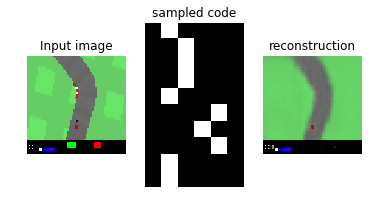

In [64]:
test_idx = 180 # interesting images in the range: 160-190
_batch = 300

# get reconstructions, logits and sampled codes from a batch of the test set
_x_hat, _logits, _z = vae_test.predict(x_test[:_batch])

subplot(131)
title("Input image")
imshow(x_test[test_idx].reshape(IMAGE_DIM), cmap='gray'), axis('off')

subplot(132)
title("sampled code")
imshow(_z[test_idx].reshape(N, M), cmap='gray'), axis('off')

subplot(133)
title("reconstruction")
imshow(_x_hat[test_idx].reshape(IMAGE_DIM), cmap='gray'), axis('off')

The GumbelSoftmax approximation to a categorical distribution, is just that, an approximation. This means the sampled code will not always be categorical, i.e. more than one non-black field in each line. Executing the above cell multiple times can reveal this (depending on the trained network). Additionally, since the code is sampled it can also change slightly from execution to execution.

## Reconstructions

Top: Input images
Bottom: Reconstructions


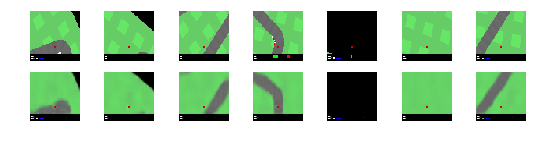

In [65]:
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(8, 2), dpi=80, facecolor='w', edgecolor='k')

from matplotlib.pyplot import subplots_adjust
subplots_adjust(wspace = 0.5, hspace=0)

diverse_obs = [230, 200, 175, 170, 160, 100, 10]

# COLUMN WISE
rows = 2
cols = len(diverse_obs)

print("Top: Input images\nBottom: Reconstructions")
for i, obs in enumerate(diverse_obs):
    i += 1
    subplot( rows, cols, i )
    imshow(x_test[obs].reshape(IMAGE_DIM), cmap='gray'), axis('off')
    
    subplot( rows, cols, i+cols )
    img_true = generator.predict(np.reshape(_z[obs], (1,-1)) )
    imshow(img_true.reshape(IMAGE_DIM), cmap='gray'), axis('off')




The reconstructions, although blurry, capture the essence of road curvature. Enough for an agent to conceiviably learn to stay on the road. 

# Interactive sample
This contains sliders to manipulate a categorical sample, used to immediately generate a sample output image. Used for interactively exploring the latent representation (code).

In [66]:
%matplotlib inline
from ipywidgets import interactive
from ipywidgets import widgets
from IPython.display import display
img_code = np.zeros( (N,M) ) # init code image

# The interactive function requires a widget element (slider) be assigned as a keyword argument, 
# matching the keyword parameters of the "f" function.
# That is the reason for the rather unintuitive function declaration "f" and building the kw_dict (keyword dictionary)

def f(*args,**kwargs):
    for i, key in enumerate(kwargs):
        zero_row = np.zeros((1,M))
        zero_row[0, kwargs[key] ] = 1
        img_code[i] = zero_row
    
    plt.subplot(121)
    plt.imshow(img_code, cmap="gray")
    
    plt.subplot(122)
    img_binary = generator.predict(np.reshape(img_code, (1,-1)) )
    plt.imshow(img_binary.reshape(IMAGE_DIM), cmap='gray')
    plt.axis('off')


kw_dict = {}
for n in range(N):
    kw_dict["z"+str(n)] = widgets.IntSlider(description="z"+str(n), min=0, max=(M-1), value=int(M/2), continuous_update=False)

interactive_plot = interactive(f, **kw_dict)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=3, continuous_update=False, description='z5', max=5), IntSlider(value=3,…

It is clear from manipulating the individual sliders, that they are hard to interpret on their own. There is no disentangled representation, where each slider would represent a concept, like curvature of the road or similar.
It is also clear that there are many non-meaningful states (combinations of slider values). But since the reconstructions from earlier look sufficient for learning the environment, is suggests that the number of necessary states is a very small subset of the possible $N \times M$ states.


# Conclusion

Using the GumbelSoftmax approach, with the decreasing temperature parameter, can produce a (very) close to categorical distribution over the latent state. And with, what appears to be, sufficient reconstructions of the input images.
The assumption is that a discrete state representation, as opposed to a continuous one, is easier for a reinforcement learning agent to learn. This will be explored the following notebook:  
name link